In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import hspace, qaoa, lhz
from scipy.optimize import minimize
from collections import defaultdict
from qiskit import QuantumCircuit, Aer, execute

We want to study a controlled action of operators in the all-to-all system of 4qubits in the LHZ formalism

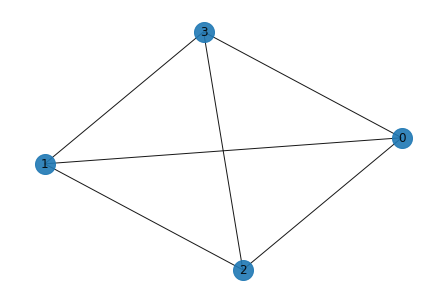

In [2]:
n=4
G = nx.Graph()
G.add_nodes_from(range(n))
G.add_edges_from(hspace.generate_edges(n))
nx.draw(G,with_labels=True,alpha=0.9,node_size=400)

We can brute force the solution by looping through all states

In [3]:
np.array([qaoa.objective(state,G) for state in hspace.generate_basis(4)]).min()

-4

In [4]:
ground_states = []
for state in hspace.generate_basis(4):
    if qaoa.objective(state,G) == -4:
        ground_states.append(state)
print(ground_states)

[[0, 0, 1, 1], [0, 1, 0, 1], [0, 1, 1, 0], [1, 0, 0, 1], [1, 0, 1, 0], [1, 1, 0, 0]]


In the parity variables they correspond to the solutions

In [5]:
parity_ground = hspace.remove_duplicates([hspace.log_to_phys(state) for state in ground_states])

In [6]:
parity_ground

[[1, 0, 1, 0, 0, 0], [0, 0, 0, 0, 1, 1], [0, 1, 0, 1, 0, 0]]

The parity Hamiltonian consists of the local field terms and T1, T2, S1 constraints

In [7]:
T_constraints = hspace.generate_T_constraints(4)
S_constraints = hspace.generate_S_constraints(4)

In [8]:
T_list = [hspace.to_parity_basis(T,4) for T in T_constraints]
S_list = [hspace.to_parity_basis(S,4) for S in S_constraints]
constraints = S_list+T_list

In [11]:
constraints

[[1, 3, 4, 5], [0, 1, 4], [1, 2, 5]]

We can check that the states `parity_ground` satisfy the holonomy constaints, filtering via the `k_body_fix` function:

In [12]:
for T in T_list:
    parity_solution = hspace.k_body_fix(T,parity_ground)[1]
for S in S_list:
    parity_solution = hspace.k_body_fix(S,parity_solution)[1]
print(parity_solution)

[[1, 0, 1, 0, 0, 0], [0, 0, 0, 0, 1, 1], [0, 1, 0, 1, 0, 0]]


For a given parity state |i_0,i_1,i_2,...,i_5>, the Hamiltonian H_LHZ evaluates to

In [13]:
def H_LHZ(state,constraints,strength = 1):
    def energy(spin):
        if spin==0:
            return -1
        if spin==1:
            return 1
    aux_state = [energy(int(spin)) for spin in state]
    energy = 0
    for spin in aux_state:
        energy+=spin
    for constraint in constraints:
        plaquette_energy = 1
        for site in constraint:
            plaquette_energy  = plaquette_energy*aux_state[site]
        energy-=plaquette_energy*strength
    return energy

In [14]:
[H_LHZ(ground_state,constraints) for ground_state in parity_ground ]

[-5, -5, -5]

In [15]:
parity_space = hspace.remove_duplicates([hspace.log_to_phys(state) for state in hspace.generate_basis(4)])

In [16]:
[H_LHZ(state,constraints) for state in parity_space]

[3, -3, -3, -5, -3, -5, -5, -3]

which in fact correspond to the ground states of the parity_space.

## Solving with QAOA

Let's first solve the Ising system with QAOA and then compile it in the LHZ scheme and solve it for QAOA again.

In [17]:
p = 5
x0=[1,1,1,1,1,1,1,1,1,1]
minimize_result = minimize(qaoa.black_box_objective(G,p),x0,method='COBYLA',options={'maxiter':2000,'disp':True})

<BarContainer object of 3 artists>

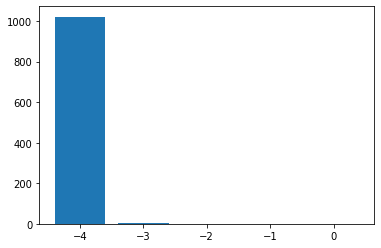

In [19]:
sol_params = minimize_result['x']
qc = qaoa.QAOA_circ(G,p,sol_params)
backend  = Aer.get_backend('qasm_simulator')
job = execute(qc,backend)
result = job.result()
corrected_counts = qaoa.invert_counts(result.get_counts())
energies = defaultdict(int)
for k, v in corrected_counts.items():
    energies[qaoa.objective(k,G)] += v
x,y = zip(*energies.items())
plt.bar(x,y)

Which reproduces the -4 minimal solution of the Ising model. 

### LHZ scheme

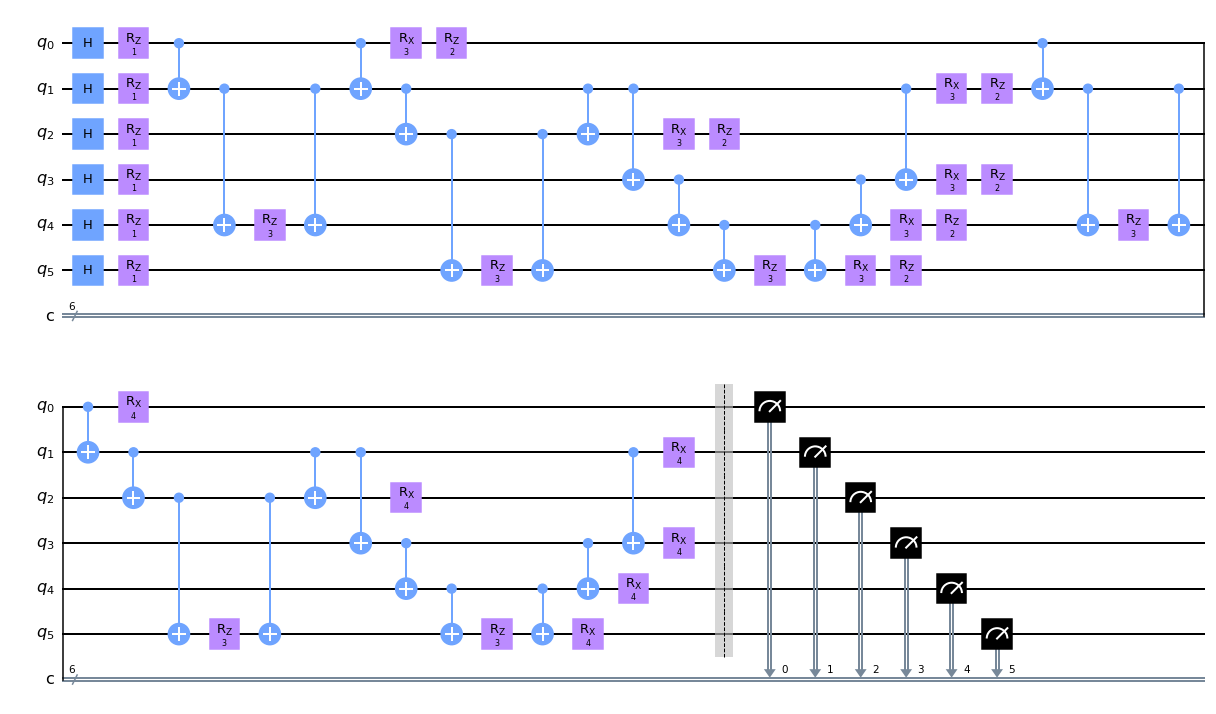

In [20]:
n=4
G = nx.Graph()
G.add_nodes_from(range(n))
G.add_edges_from(hspace.generate_edges(n))
params = [1,2,3,4]
p=2
qc = lhz.LHZ_QAOA(G,p,params)
qc.draw('mpl')

In [21]:
def objective(state,n_logical,omega=3):
    T_constraints = hspace.generate_T_constraints(n_logical)
    S_constraints = hspace.generate_S_constraints(n_logical)
    T_list = [hspace.to_parity_basis(T,n_logical) for T in T_constraints]
    S_list = [hspace.to_parity_basis(S,n_logical) for S in S_constraints]
    constraints = S_list+T_list
    def energy(spin):
        if spin==0:
            return -1
        if spin==1:
            return 1
    aux_state = [energy(int(spin)) for spin in state]
    energy = 0
    for spin in aux_state:
        energy+=spin
    for constraint in constraints:
        plaquette_energy = 1
        for site in constraint:
            plaquette_energy  = plaquette_energy*aux_state[site]
        energy-=plaquette_energy*omega
    return energy

In [22]:
def sample_vev(result):
    counts = qaoa.invert_counts(result.get_counts())
    acc = 0
    for state in counts.keys():
        acc+= objective(state,4)*counts[state]
    counts.values()
    total_counts = 0
    for count in counts.values():
        total_counts += count
    return acc/total_counts

In [23]:
def black_box_objective(G,p):
    backend  = Aer.get_backend('qasm_simulator')
    def f(params):
        qc = lhz.LHZ_QAOA(G,p,params)
        job = execute(qc,backend)
        result = job.result()
        return sample_vev(result)
    return f

In [24]:
backend  = Aer.get_backend('qasm_simulator')
job = execute(qc,backend)
result = job.result()
print(qaoa.invert_counts(result.get_counts()))

{'000011': 2, '000100': 1, '100000': 1, '111010': 7, '110001': 6, '101100': 6, '011010': 5, '010011': 3, '110100': 2, '001101': 3, '001001': 2, '011110': 10, '000111': 9, '101011': 17, '010111': 19, '011001': 2, '100111': 12, '100101': 3, '111001': 13, '100001': 3, '101001': 8, '001100': 2, '000010': 1, '110111': 86, '111000': 5, '111101': 34, '101010': 9, '111110': 54, '100110': 3, '101111': 80, '111111': 262, '110011': 25, '001111': 28, '111011': 64, '100100': 2, '110110': 18, '011011': 23, '000000': 1, '110101': 17, '011101': 15, '001011': 3, '101101': 17, '000101': 1, '011100': 1, '101110': 9, '001010': 3, '010010': 3, '111100': 9, '110000': 5, '101000': 2, '110010': 4, '011111': 79, '010101': 9, '010110': 5, '100011': 6, '001110': 5}


In [25]:
p = 5
#x0=np.random.rand(10)
x0 = [0.9167816,  0.66382941, 0.41845452, 0.68850524, 0.33163619, 0.54148793,
 0.04703343, 0.51072126, 0.23248019, 0.83924367]
print(x0)
minimize_result = minimize(black_box_objective(G,p),x0,method='COBYLA',options={'maxiter':2000,'disp':True})
minimize_result

[0.9167816, 0.66382941, 0.41845452, 0.68850524, 0.33163619, 0.54148793, 0.04703343, 0.51072126, 0.23248019, 0.83924367]


     fun: -10.095703125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 120
  status: 1
 success: True
       x: array([ 1.84357752,  1.6223067 ,  0.6315999 ,  0.77373477,  0.27968997,
        0.64052555, -0.38943357,  1.95896173,  0.38659023,  0.5869358 ])

In [26]:
sol_params = minimize_result['x']
qc = lhz.LHZ_QAOA(G,p,sol_params)
backend  = Aer.get_backend('qasm_simulator')
job = execute(qc,backend)
result = job.result()
corrected_counts = qaoa.invert_counts(result.get_counts())

In [27]:
corrected_counts

{'000101': 2,
 '010101': 1,
 '001011': 1,
 '000110': 1,
 '100100': 1,
 '010011': 10,
 '000010': 4,
 '110110': 1,
 '110001': 10,
 '001101': 2,
 '010100': 9,
 '000100': 1,
 '110011': 9,
 '011010': 7,
 '010001': 2,
 '110000': 1,
 '000000': 4,
 '010000': 2,
 '011011': 14,
 '000001': 1,
 '100111': 1,
 '000111': 2,
 '000011': 937,
 '010110': 1}

In [34]:
[objective(state,4) for state in parity_space]

[-3, -9, -9, -11, -9, -11, -11, -9]

As we can see from the count, the Quantum Annealing converges to the solution |000011>